# Hallucination Score Analysis

In this notebook, the hallucination scores of the methods are analyzed.

In [1]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.preprocessing import binarize


## Utility Functions

In [2]:
# LOADING
# load the dataframes and durations from the results folder
def load_dataframes(f):
    dataset_name = f.split("__")[0].split("_")[-4]
    model_name = f.split(dataset_name)[0].split("\\")[-1] +"_"+ f.split("__")[-1].split(".")[0]
    df = pd.read_csv(f)
    df.drop([col for col in df.columns if "answer" in col or "prompt" in col], axis=1, inplace=True)
    durations = f.split(dataset_name)[0] + "durations.csv"
    durations_df = pd.read_csv(durations) if len(glob.glob(durations)) > 0 else None
    return {"dataset_name": dataset_name, "model": model_name, "df": df, "durations": durations_df}
# --------------------------------

# PREPROCESSING
# fix json errors in the column lbhd_score
def fix_json_errors(df):
    print("Starting to fix JSON errors...")
    for index, row in df.iterrows():
        json_str = row['lbhd_score'].replace("'", "\"")
        while True:
            try:
                # Attempt to parse the JSON string
                json.loads(json_str)
                break  # Exit the loop if no error
            except json.JSONDecodeError as e:
                # If there's a JSONDecodeError, extract the position of the error
                error_pos = e.pos
                print(f"Fixing error in row {index} at position: {error_pos}")
                # Add a backslash to the string in front of the error to escape the character
                json_str = json_str[:error_pos - 1] + "\\" + json_str[error_pos - 1:]
                # Replace the JSON string in the DataFrame with the corrected one
                df.at[index, 'lbhd_score'] = json_str
    return df

# normalize the columns
def normalize_column(column):
    # Apply Min-Max normalization
    column = (column - column.min()) / (column.max() - column.min())
    # rescale to [0, 1] range (from [-1, 1] range)
    column = (column + 1) / 2
    return column

# process the lbhd_score column
def process_lbhd_scores(df):
    # Initialize new columns with default values
    df['lbhd_sent_avg'] = 0.0
    df['lbhd_sent_min'] = 0.0
    df['lbhd_sent_normalized_product'] = 0.0
    df['lbhd_concept_avg'] = 0.0
    df['lbhd_concept_min'] = 0.0
    df['lbhd_concept_normalized_product'] = 0.0
    # Iterate over each row to process the 'lbhd_score' column
    for index, row in df.iterrows():
        # Parse the string representation of the dictionary into an actual dictionary
        lbhd_score = json.loads(row['lbhd_score'].replace("'", "\""))        
        # Extract the low-level scores
        df.at[index, 'lbhd_sent_avg'] = lbhd_score['avg']
        df.at[index, 'lbhd_sent_min'] = lbhd_score['min']
        df.at[index, 'lbhd_sent_normalized_product'] = lbhd_score['normalized_product']        
        # Aggregate the concept-level scores
        concept_avgs = [concept[next(iter(concept))]['avg'] for concept in lbhd_score['concepts']]
        concept_mins = [concept[next(iter(concept))]['min'] for concept in lbhd_score['concepts']]
        concept_norm_prods = [concept[next(iter(concept))]['normalized_product'] for concept in lbhd_score['concepts']]        
        df.at[index, 'lbhd_concept_avg'] = np.mean(concept_avgs)
        df.at[index, 'lbhd_concept_min'] = np.min(concept_mins)
        def normalized_product(probabilities):
            adjusted_probs = [max(p, 1e-30) for p in probabilities]
            log_probs = np.log(adjusted_probs)
            score = np.exp(np.sum(log_probs) / len(adjusted_probs))
            return score
        df.at[index, 'lbhd_concept_normalized_product'] = normalized_product(concept_norm_prods)
    # Remove the 'lbhd_score' column
    df.drop('lbhd_score', axis=1, inplace=True)

    # Normalize the new columns
    df['lbhd_sent_avg'] = normalize_column(df['lbhd_sent_avg'])
    df['lbhd_sent_min'] = normalize_column(df['lbhd_sent_min'])
    df['lbhd_sent_normalized_product'] = normalize_column(df['lbhd_sent_normalized_product'])
    df['lbhd_concept_avg'] = normalize_column(df['lbhd_concept_avg'])
    df['lbhd_concept_min'] = normalize_column(df['lbhd_concept_min'])
    df['lbhd_concept_normalized_product'] = normalize_column(df['lbhd_concept_normalized_product'])
    # reverse calculation of: linear_probs = [(prob + 1) / 2 for prob in linear_probs]
    for col in df.columns:
        if "lbhd" in col:
            df[col] = (df[col] * 2) - 1
    return df
# --------------------------------

# EVALUATION
# calculate the metrics (AUC-ROC, AUC-PR, Precision, Recall, F1) for each column
def calculate_metrics(df):
    metrics = {}
    for column in df.columns:
        ground_truth = df['ground_truth'].values
        score = df[column].values
        # Calculate AUC-ROC
        auc_roc = roc_auc_score(ground_truth, score)
        # Calculate AUC-PR
        auc_pr = average_precision_score(ground_truth, score)
        # Binarize predictions based on a threshold (e.g., 0.5)
        threshold = 0.5
        binarized_score = binarize(score.reshape(-1, 1), threshold=threshold).reshape(-1)
        # Calculate Precision, Recall, F1, and F2 scores
        precision = precision_score(ground_truth, binarized_score)
        recall = recall_score(ground_truth, binarized_score)
        f1 = f1_score(ground_truth, binarized_score)

        metrics[column] = {"AUC-ROC": auc_roc, "AUC-PR": auc_pr, "Precision": precision, "Recall": recall, "F1": f1}
    return metrics


# VISUALIZATION
def plot_correlation_matrix(df, model_name, dataset_name):
    # Ensure 'ground_truth' is the last column
    columns = [col for col in df.columns if col != 'ground_truth'] + ['ground_truth']
    df = df[columns]
    # Compute the correlation matrix
    corr = df.corr()
    # Identify the 3 strongest correlations with 'ground_truth' by absolute value, excluding itself
    strongest_corr = corr['ground_truth'].drop('ground_truth').abs().nlargest(3).index.tolist()
    fig, ax = plt.subplots(figsize=(11, 9))
    cmap = "YlGnBu"
    # Draw the heatmap with the correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=True, fmt=".2f", annot_kws={"size": 7},
                mask=np.triu(np.ones_like(corr, dtype=bool)))  # Mask for the upper triangle
    # Highlight the columns and rows of the 3 strongest correlations
    for strong_corr in strongest_corr:
        if not np.tril(np.ones_like(corr, dtype=bool))[df.columns.get_loc(strong_corr), len(df.columns) - 1]:
            ax.add_patch(Rectangle((df.columns.get_loc(strong_corr), len(df.columns) - 1), 1, 1, fill=False, edgecolor='red', lw=3))
        if not np.tril(np.ones_like(corr, dtype=bool))[len(df.columns) - 1, df.columns.get_loc(strong_corr)]:
            ax.add_patch(Rectangle((len(df.columns) - 1, df.columns.get_loc(strong_corr)), 1, 1, fill=False, edgecolor='red', lw=3))
    ax.set_xticks(np.arange(len(corr.columns)) + .5)
    ax.set_yticks(np.arange(len(corr.columns)) + .5)
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr.columns)
    # Set title with model and dataset names
    dataset_name = "Natural Questions" if dataset_name == "nqopen" else "XSum" if dataset_name == "xsum" else dataset_name
    plt.title(f'Correlation Matrix for {model_name}\non dataset {dataset_name} with Highlights', fontsize=16, pad=20)
    # Adjust layout to fit everything
    plt.tight_layout()
    # Display the plot
    plt.show()


## Loading the scores

In [3]:
# load datasets
# find all csvs with scores and ground truths
files = glob.glob("results/*with_ground_truths*.csv")

# load all csvs into a list of dataframes
datasets = [load_dataframes(f) for f in files]

print(f"Found {len(datasets)} CSVs with scores and ground truths for analysis:\n")
for dataset in datasets:
    print(f"Dataset: {dataset['dataset_name']}")
    print(f"LLM: {dataset['model']}")
    print(f"Shape: {dataset['df'].shape}\n")

Found 6 CSVs with scores and ground truths for analysis:

Dataset: nqopen
LLM: openai__gpt-3-5-turbo
Shape: (80, 6)

Dataset: xsum
LLM: openai__gpt-3-5-turbo
Shape: (80, 6)

Dataset: nqopen
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: nqopen
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)



In [4]:
test_df = datasets[0]["df"]
test_df.head(2)

,fleek_score,selfcheck_nli_score,selfcheck_bert_score,lm_v_lm_score,lbhd_score,ground_truth
0,0.0,0.049175,0.167182,0.0,"{'avg': 0.9644255675958286, 'normalized_produc...",0.0
1,0.0,0.992679,0.348210,0.0,"{'avg': 0.9406606117559376, 'normalized_produc...",0.0


In [5]:
# process LBHD scores
test_df = fix_json_errors(test_df)
test_df = process_lbhd_scores(test_df)   # aggregate concept-level scores and normalize (min-max)
test_df.head(10)

Starting to fix JSON errors...
Fixing error in row 1 at position: 229
Fixing error in row 1 at position: 344
Fixing error in row 27 at position: 121
Fixing error in row 35 at position: 226
Fixing error in row 46 at position: 121
Fixing error in row 53 at position: 244
Fixing error in row 57 at position: 231
Fixing error in row 59 at position: 114
Fixing error in row 60 at position: 115
Fixing error in row 76 at position: 231


,fleek_score,selfcheck_nli_score,selfcheck_bert_score,lm_v_lm_score,ground_truth,lbhd_sent_avg,lbhd_sent_min,lbhd_sent_normalized_product,lbhd_concept_avg,lbhd_concept_min,lbhd_concept_normalized_product
0,0.0,0.049175,0.167182,0.0,0.0,0.825612,0.773267,0.860816,0.949143,0.761935,0.953476
1,0.0,0.992679,0.348210,0.0,0.0,0.704760,0.371723,0.718119,0.915439,0.832743,0.925991
2,0.0,0.002411,0.260011,0.0,0.0,0.805633,0.667007,0.837591,0.963932,0.860099,0.968383
3,0.0,0.002031,0.260233,0.0,1.0,0.761295,0.765373,0.808643,0.903477,0.754156,0.911433
4,1.0,0.200661,0.416712,0.0,1.0,0.539293,0.437369,0.601633,0.769746,0.430959,0.772439
5,-1.0,0.134247,0.330633,0.0,0.0,0.554575,0.319086,0.574216,0.838159,0.570367,0.844820
6,0.0,0.004102,0.398616,0.0,1.0,0.737935,0.589252,0.778618,0.889548,0.580616,0.888672
7,0.0,0.001529,0.263676,0.0,0.0,0.709441,0.314664,0.695795,0.820243,0.310053,0.782410
8,-1.0,0.414411,0.413372,1.0,0.0,0.334873,0.415781,0.419914,0.635188,0.409688,0.634640
9,0.0,0.001360,0.192370,0.0,0.0,0.919741,0.725936,0.931866,0.998646,0.996834,0.998872


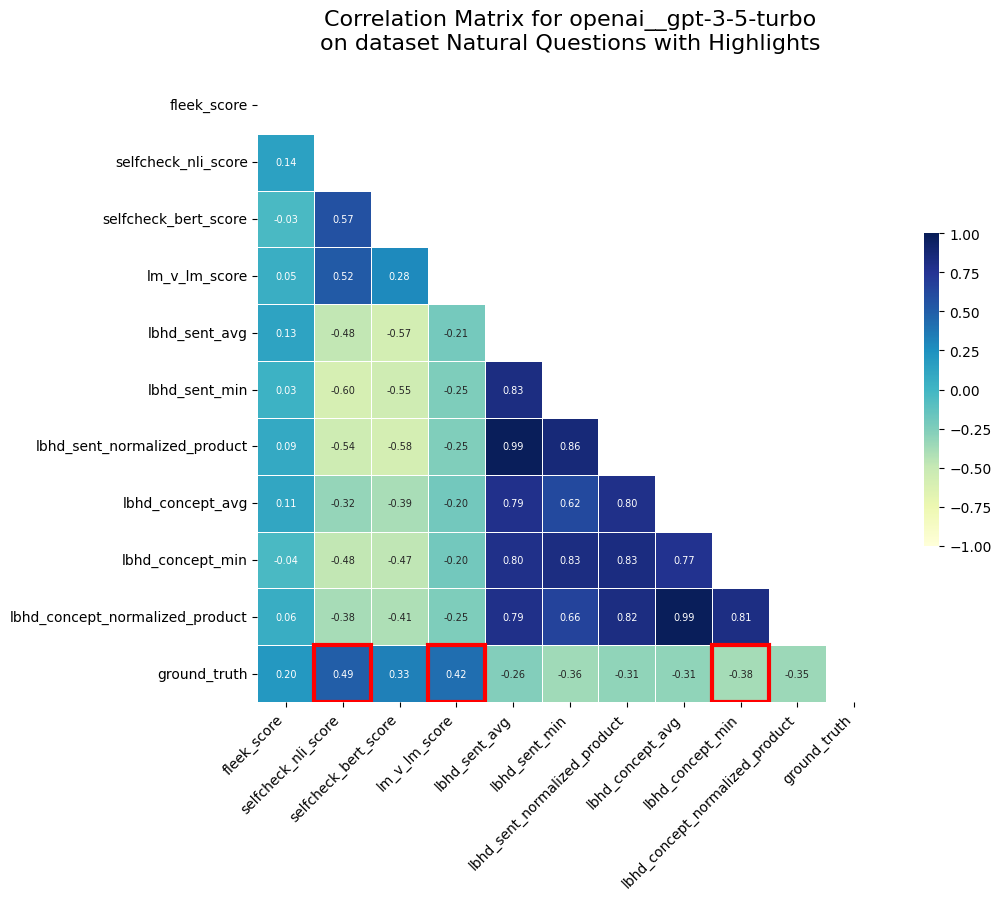

In [6]:
plot_correlation_matrix(test_df, datasets[0]["model"], datasets[0]["dataset_name"])

In [7]:
# Calculate metrics for the 'lbhd_concept_min' column
metrics = calculate_metrics(test_df)


print(f"Precision: {metrics['lbhd_concept_min']['Precision']}")
print(f"Recall: {metrics['lbhd_concept_min']['Recall']}")
print(f"F1: {metrics['lbhd_concept_min']['F1']}")
print(f"AUC-ROC: {metrics['lbhd_concept_min']['AUC-ROC']}")
print(f"AUC-PR: {metrics['lbhd_concept_min']['AUC-PR']}")

Precision: 0.11475409836065574
Recall: 0.4666666666666667
F1: 0.18421052631578946
AUC-ROC: 0.2594871794871795
AUC-PR: 0.130228593494441


<Axes: xlabel='lbhd_concept_min', ylabel='Count'>

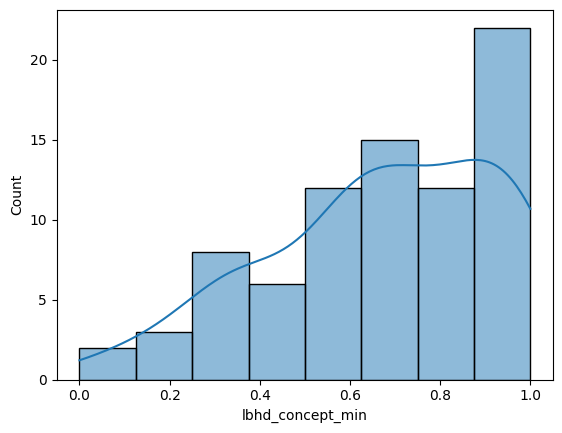

In [8]:
# look at lbhf_concept_min: distribution of scores
sns.histplot(test_df['lbhd_concept_min'], kde=True)